In [2]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw

# === CONFIG ===
INPUT_DIR = "glyph_images"
YOLO_DATA_DIR = "yolo_dataset"

# === LOAD GLYPHS ===
# Assuming this part is in a cell after INPUT_DIR is defined
glyph_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
glyph_classes = {f: idx for idx, f in enumerate(glyph_files)}
num_classes = len(glyph_classes)

In [3]:
# === GENERATE data.yaml (Your first snippet, made dynamic) ===
print("Generating glyphs-seg.yaml...")
yaml_txt = f"""
path: {os.path.abspath(YOLO_DATA_DIR)}
train: images/train
val: images/val

nc: {num_classes}
names:
"""

# Dynamically generate names based on your glyph_classes
# Ensure the names are ordered by their class ID
class_names_ordered = [f_name.split('.')[0] for f_name, idx in sorted(glyph_classes.items(), key=lambda item: item[1])]

for cid, name in enumerate(class_names_ordered):
    yaml_txt += f"  {cid}: {name}\n"

with open(os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"), "w") as f:
    f.write(yaml_txt)

print("glyphs-seg.yaml generated.")

Generating glyphs-seg.yaml...
glyphs-seg.yaml generated.


In [ ]:
# ─── TRAIN SEGMENTATION MODEL ─────────────────────────────────────────────────
model = YOLO("yolo11n.pt", task="detect")

# Move to GPU if available
if torch.cuda.is_available():
    model.to("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available: falling back to CPU")

model.train(
    data=os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"),
    epochs=50,
    imgsz=640,
    batch=32,
    patience=5,
    workers=8,
    cos_lr=True,              # Use cosine learning rate scheduler
    mosaic=0.8,               # Mosaic data augmentation probability
    project="runs/detect",    # Project directory
    name="cuneiform_detection", # Run name
    plots=True,               # Generate plots for metrics visualization
)

# ─── SAVE MODEL ────────────────────────────────────────────────────
model_save_path = "models/glyph_detector.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

best_weights = "runs/detect/cuneiform_detection/weights/best.pt"
if os.path.exists(best_weights):
    shutil.copy(best_weights, model_save_path)
    print("Done: synthetic data with jitter & segmentation training complete!")
    print(f"Model saved to: {model_save_path}")
else:
    print("Training might not have produced weight files yet.")
    print("Please check 'runs/segment/train/weights/' directory after training completes.")


🔌 Using GPU: Tesla V100-PCIE-16GB
New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_dataset/glyphs-seg.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=cuneiform_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /home/default/AI-project/yolo_dataset/labels/train... 80000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80000/80000 [05:06<00:00, 260.97it/s]


train: New cache created: /home/default/AI-project/yolo_dataset/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.3±4.0 MB/s, size: 134.2 KB)


val: Scanning /home/default/AI-project/yolo_dataset/labels/val... 15523 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15523/15523 [00:58<00:00, 263.67it/s]


val: New cache created: /home/default/AI-project/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/cuneiform_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/05/23 23:37:14 INFO mlflow.tracking.fluent: Experiment with name 'runs/detect' does not exist. Creating a new experiment.


MLflow: logging run_id(59a327dd12264d14baf1676a7bb62bcd) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/cuneiform_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.3G     0.8157      5.292     0.9238        553        640: 100%|██████████| 2500/2500 [11:38<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:46<00:00,  2.28it/s]


                   all      15523     154646     0.0117       0.34     0.0272     0.0255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.5G     0.5751      2.667     0.8804        664        640: 100%|██████████| 2500/2500 [11:23<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:18<00:00,  3.08it/s]


                   all      15523     154646      0.612      0.655      0.683      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.5G     0.5473      1.456      0.871        595        640: 100%|██████████| 2500/2500 [11:08<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:11<00:00,  3.38it/s]


                   all      15523     154646      0.853      0.877       0.92      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.5G     0.4917     0.9881     0.8553        589        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:09<00:00,  3.50it/s]


                   all      15523     154646      0.944      0.944      0.973      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.4G     0.4375     0.7893     0.8394        604        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:08<00:00,  3.54it/s]


                   all      15523     154646      0.968      0.966      0.984      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.4G     0.4083     0.6909     0.8318        657        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:08<00:00,  3.55it/s]


                   all      15523     154646      0.977      0.976      0.987      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.4G     0.3895     0.6328     0.8265        630        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:08<00:00,  3.57it/s]


                   all      15523     154646      0.979       0.98      0.989      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.4G      0.375      0.591     0.8223        560        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:08<00:00,  3.57it/s]


                   all      15523     154646      0.982      0.982       0.99      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.4G     0.3644     0.5604     0.8197        536        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:08<00:00,  3.57it/s]


                   all      15523     154646      0.983      0.984       0.99       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.4G     0.3561     0.5366     0.8167        617        640: 100%|██████████| 2500/2500 [11:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:07<00:00,  3.59it/s]


                   all      15523     154646      0.984      0.986       0.99       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.4G     0.3488     0.5182     0.8154        515        640: 100%|██████████| 2500/2500 [11:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:07<00:00,  3.58it/s]


                   all      15523     154646      0.984      0.986      0.991      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.4G     0.3435     0.5078     0.8138        460        640:  16%|█▌        | 392/2500 [01:44<09:24,  3.73it/s]

In [ ]:
model_save_path = "yolo_classifier/best.pt"

# continue training from previous weights if available
if os.path.exists(model_save_path):
    print(f"Continuing training from {model_save_path}...")
    model = YOLO(model_save_path)
else:
    print("No previous model found")
    raise FileNotFoundError(f"Model weights not found at {model_save_path}. Please train the model first.")

# Continue training the model with the new dataset
model.train(
    data=os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"),
    epochs=25,
    imgsz=640,
    batch=32,
    patience=5,
    workers=8,
    cos_lr=True,              # Use cosine learning rate scheduler
    mosaic=0.8,               # Mosaic data augmentation probability
    project="runs/detect",    # Project directory
    name="cuneiform_detection_continued", # Run name
    plots=True,               # Generate plots for metrics visualization
)

# ─── SAVE MODEL ────────────────────────────────────────────────────
model_save_path = "yolo_classifier/best_cont.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

best_weights = "runs/detect/cuneiform_detection_continued/weights/best.pt"
if os.path.exists(best_weights):
    shutil.copy(best_weights, model_save_path)
    print("Done: synthetic data with jitter & segmentation training complete!")
    print(f"Model saved to: {model_save_path}")
else:
    print("Training might not have produced weight files yet.")
    print("Please check 'runs/segment/train/weights/' directory after training completes.")

In [ ]:
model_save_path = "yolo_classifier/best.pt"

# continue training from previous weights if available
if os.path.exists(model_save_path):
    print(f"Continuing training from {model_save_path}...")
    model = YOLO(model_save_path)
else:
    print("No previous model found")
    raise FileNotFoundError(f"Model weights not found at {model_save_path}. Please train the model first.")

# Continue training the model with the new dataset
model.train(
    data=os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"),
    epochs=10,
    imgsz=640,
    batch=32,
    patience=5,
    workers=4,
    cos_lr=True,              # Use cosine learning rate scheduler
    mosaic=0.8,               # Mosaic data augmentation probability
    project="runs/detect",    # Project directory
    name="cuneiform_detection_continued", # Run name
    plots=True,               # Generate plots for metrics visualization
    amp=True,                   # Mixed precision
)

# ─── SAVE MODEL ────────────────────────────────────────────────────
model_save_path = "yolo_classifier/best_cont.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

best_weights = "runs/detect/cuneiform_detection_continued2/weights/best.pt"
if os.path.exists(best_weights):
    shutil.copy(best_weights, model_save_path)
    print("Done: synthetic data with jitter & segmentation training complete!")
    print(f"Model saved to: {model_save_path}")
else:
    print("Training might not have produced weight files yet.")
    print("Please check 'runs/segment/train/weights/' directory after training completes.")

Continuing training from yolo_classifier/best.pt...
New https://pypi.org/project/ultralytics/8.3.144 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_dataset/glyphs-seg.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_classifier/best.pt, momentum=0.937, mosaic=0.

train: Scanning /home/default/AI-project/yolo_dataset/labels/train.cache... 80000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80000/80000 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2432.9±1155.3 MB/s, size: 157.5 KB)


val: Scanning /home/default/AI-project/yolo_dataset/labels/val.cache... 20000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


Plotting labels to runs/detect/cuneiform_detection_continued2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
MLflow: logging run_id(7b0b2f90363049f79ab0d1a38496878c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/cuneiform_detection_continued2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.3G     0.2446     0.2789     0.7873        303        640: 100%|██████████| 2500/2500 [11:40<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


                   all      20000     199211      0.982      0.985      0.991      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.3G     0.2598     0.3046     0.7908        305        640:  80%|███████▉  | 1998/2500 [09:09<02:14,  3.74it/s]

In [ ]:
# Launch TensorBoard
import subprocess
from IPython.display import IFrame

TB_PORT = 6006
subprocess.Popen(["tensorboard", "--logdir", "runs/detect", "--port", str(TB_PORT)])

# Display TensorBoard in the notebook (if running in Jupyter/Colab)
display(IFrame(f"http://localhost:{TB_PORT}", width=1200, height=800))

print(f"✅ TensorBoard started! If not visible above, navigate to http://localhost:{TB_PORT} in your browser")


0: 128x640 1 cuneiform_U12003, 1 cuneiform_U12034, 1 cuneiform_U12069, 1 cuneiform_U120F4, 1 cuneiform_U121D8, 1 cuneiform_U12270, 1 cuneiform_U122C8, 1 cuneiform_U1233E, 1 cuneiform_U12361, 1 cuneiform_U12383, 58.5ms
Speed: 8.0ms preprocess, 58.5ms inference, 479.8ms postprocess per image at shape (1, 3, 128, 640)


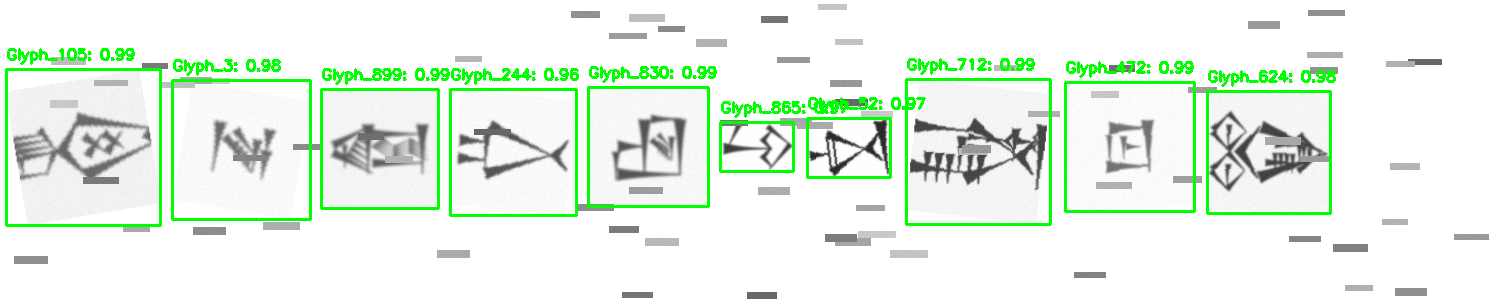

✅ Done: Testing complete, results displayed!


In [3]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display
model = YOLO('yolo_classifier/best_continued.pt')

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
TEST_IMG_PATH = "yolo_dataset/images/val/sentence_88888.png"  # Path to a single test image

# ─── TEST PREDICTIONS ON SINGLE IMAGE ─────────────────────────────────────────
def test_model_on_image(img_path):
    # Load the test image
    img = Image.open(img_path)
    
    # Perform segmentation prediction
    results = model(img)  # Use the pre-trained model
    
    # The results are now a list of detections
    result = results[0]  # The first (and only) result
    
    # Get predictions (boxes, scores, etc.)
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (xyxy format)
    confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = result.boxes.cls.cpu().numpy()  # Class IDs
    
    # Convert image for visualization (RGB -> BGR for OpenCV)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Draw predictions on the image
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
        
        # Draw label and confidence
        label = f"Glyph_{int(class_id)}: {conf:.2f}"
        cv2.putText(img_cv2, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert back to RGB for displaying with PIL
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    
    # Display in Jupyter Notebook
    display(img_pil)

# Test the model on the single image
test_model_on_image(TEST_IMG_PATH)

print("✅ Done: Testing complete, results displayed!")


In [4]:
import pandas as pd

display(pd.read_csv('runs/detect/cuneiform_detection/results.csv'))
display(pd.read_csv('runs/detect/cuneiform_detection_continued/results.csv'))

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,832.365,0.81571,5.29238,0.92380,0.01174,0.34035,0.02724,0.02547,0.30277,3.49648,0.79930,0.003332,0.003332,0.003332
1,2,1622.720,0.57508,2.66706,0.88035,0.61185,0.65484,0.68289,0.65521,0.28004,1.28129,0.79455,0.006659,0.006659,0.006659
2,3,2387.210,0.54731,1.45595,0.87100,0.85335,0.87690,0.92046,0.89260,0.25892,0.60492,0.78914,0.009959,0.009959,0.009959
3,4,3136.790,0.49172,0.98811,0.85526,0.94386,0.94387,0.97296,0.95519,0.20669,0.36235,0.77795,0.009912,0.009912,0.009912
4,5,3882.390,0.43751,0.78928,0.83938,0.96822,0.96609,0.98371,0.96879,0.19075,0.27925,0.77407,0.009843,0.009843,0.009843
5,6,4626.690,0.40830,0.69089,0.83176,0.97669,0.97568,0.98736,0.97428,0.18099,0.24105,0.77181,0.009756,0.009756,0.009756
6,7,5369.840,0.38954,0.63282,0.82651,0.97895,0.97956,0.98864,0.97710,0.17209,0.22144,0.77028,0.009649,0.009649,0.009649
7,8,6112.350,0.37497,0.59103,0.82229,0.98224,0.98242,0.98973,0.97870,0.16798,0.20627,0.76946,0.009525,0.009525,0.009525
8,9,6854.390,0.36439,0.56042,0.81966,0.98277,0.98397,0.99001,0.97972,0.16348,0.19550,0.76857,0.009382,0.009382,0.009382
9,10,7595.500,0.35612,0.53658,0.81671,0.98365,0.98580,0.99036,0.98028,0.16098,0.18915,0.76821,0.009222,0.009222,0.009222


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,788.896,0.26635,0.36618,0.79517,0.98373,0.98738,0.99133,0.98151,0.16042,0.17520,0.76636,0.003332,0.003332,0.003332
1,2,1563.730,0.28181,0.38734,0.79832,0.98658,0.98661,0.99141,0.98236,0.15845,0.17112,0.76613,0.006639,0.006639,0.006639
2,3,2323.890,0.31159,0.42393,0.80564,0.98334,0.98568,0.99095,0.98024,0.16352,0.18229,0.76781,0.009842,0.009842,0.009842
3,4,3082.660,0.33326,0.46430,0.81224,0.98445,0.98608,0.99092,0.98221,0.15613,0.17185,0.76627,0.009649,0.009649,0.009649
4,5,3841.530,0.32881,0.45686,0.81184,0.98752,0.98711,0.99124,0.98255,0.15251,0.16167,0.76568,0.009382,0.009382,0.009382
5,6,4600.420,0.32342,0.45016,0.81014,0.98719,0.99000,0.99167,0.98335,0.15015,0.15429,0.76504,0.009046,0.009046,0.009046
6,7,5358.960,0.31821,0.43922,0.80908,0.98713,0.99098,0.99154,0.98336,0.14777,0.15027,0.76459,0.008646,0.008646,0.008646
7,8,6117.420,0.31265,0.43257,0.80742,0.98806,0.99140,0.99185,0.98385,0.14572,0.14602,0.76410,0.008189,0.008189,0.008189
8,9,6876.200,0.30729,0.42448,0.80614,0.98822,0.99167,0.99176,0.98391,0.14528,0.14328,0.76405,0.007681,0.007681,0.007681
9,10,7634.620,0.30094,0.41477,0.80440,0.98824,0.99170,0.99182,0.98408,0.14396,0.14268,0.76371,0.007132,0.007132,0.007132
